In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ruta del archivo CSV
csv_path = "dataset_final_2.csv"

# Cargar el DataFrame
df_rnn_final = pd.read_csv(csv_path)

# Mostrar primeras filas para verificar
print("Datos cargados:")
# Seleccionar solo las columnas numéricas que usaremos como input
features_columns = [
    'temporal_1', 'temporal_2', 'temporal_3',
    'is_weekend', 'season_encoded', 'is_holiday',
    'year', 'month', 'weekday',
    'consumo_semanal_usuario'
]

# Opcional: agrega rating_previous si lo calculaste
# features_columns.append('rating_previous')

X = df_rnn_final[features_columns].values
y = df_rnn_final['rating'].values  # El objetivo a predecir
from collections import defaultdict

# Diccionario para guardar secuencias por usuario
user_sequences = defaultdict(list)
user_targets = defaultdict(list)

# Recorremos todo el dataset y vamos guardando por usuario
for idx, row in df_rnn_final.iterrows():
    user_id = row['userId']
    x = row[features_columns].values
    target = row['rating']

    user_sequences[user_id].append(x)
    user_targets[user_id].append(target)


Datos cargados:


In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convertimos a listas
sequences_list = list(user_sequences.values())
targets_list = np.array([np.mean(t) for t in user_targets.values()])  # promedio del rating del usuario, o puedes usar último valor

# Padding (rellenar con ceros al inicio)
maxlen = 50  # Máximo 50 interacciones por usuario
X_padded = pad_sequences(sequences_list, maxlen=maxlen, padding='pre', dtype='float32')

print("Forma de X_padded:", X_padded.shape)
print("Forma de y:", targets_list.shape)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_padded, targets_list, test_size=0.2, random_state=42)



Forma de X_padded: (200384, 50, 10)
Forma de y: (200384,)


c:\Python312\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 50, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,265 (75.25 KB)

 Trainable params: 19,265 (75.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - loss: 2.4205 - mae: 1.1758 - val_loss: 0.3537 - val_mae: 0.4619
Epoch 2/15
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.6300 - mae: 0.6263 - val_loss: 0.3479 - val_mae: 0.4579
Epoch 3/15
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - loss: 0.4548 - mae: 0.5276 - val_loss: 0.3453 - val_mae: 0.4557
Epoch 4/15
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - loss: 0.3659 - mae: 0.4686 - val_loss: 0.3398 - val_mae: 0.4487
Epoch 5/15
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - loss: 0.3440 - mae: 0.4521 - val_loss: 0.3403 - val_mae: 0.4498
Epoch 6/15
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - loss: 0.3411 - mae: 0.4500 - val_loss: 0.3399 - val_mae: 0.4497
Epoch 7/15
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - loss: 0.3423 - mae: 0.4507 - val_loss: 0.3407 - val_mae: 0.4510
Epoch 8/15
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - loss: 0.3382 - mae: 0.4470 - val_loss: 0.3400 - val_mae: 0.4483
Epoch 9/15
2505/2505 ━━━

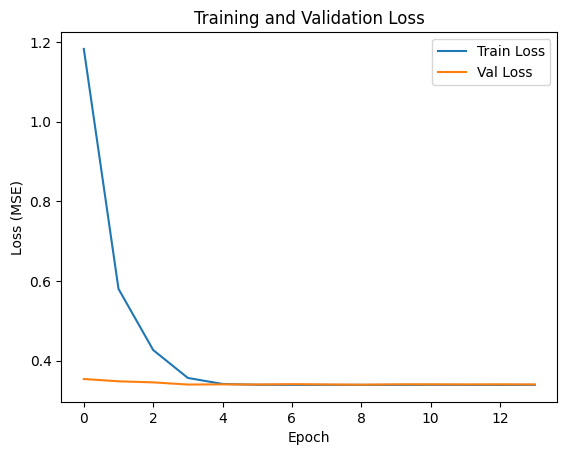

Modelo guardado como 'rnn_rating_model.h5'


In [4]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping

# Parámetros del modelo
input_shape = (X_train.shape[1], X_train.shape[2])  # maxlen, n_features
lstm_units = 64
dropout_rate = 0.4
learning_rate = 0.001

# Construcción del modelo
model = Sequential()

# Opcional: Capa Masking si usas padding ('mask_zero=True' en Embedding o aquí)
model.add(Masking(mask_value=0., input_shape=input_shape))

# Capa LSTM
model.add(LSTM(units=lstm_units, return_sequences=False))  # False porque solo queremos 1 salida por secuencia
model.add(Dropout(dropout_rate))

# Capa densa final para regresión
model.add(Dense(units=1, activation='linear'))  # Salida lineal para predecir el rating

# Compilación del modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mse',           # Error cuadrático medio
    metrics=['mae']       # Métrica adicional: error absoluto medio
)

# Mostrar resumen del modelo
model.summary()

# Callback para detener el entrenamiento si deja de mejorar
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Evaluar en test
loss, mae = model.evaluate(X_test, y_test, verbose=0)

# Predecir y calcular RMSE manualmente
y_pred = model.predict(X_test, batch_size=64).flatten()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Mostrar resultados finales
print(f"\n✅ Test Loss (MSE): {loss:.4f}")
print(f"✅ Test MAE: {mae:.4f}")
print(f"✅ Test RMSE: {rmse:.4f}")

import matplotlib.pyplot as plt

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Guardar modelo completo
model.save("rnn_rating_model12.h5")
print("Modelo guardado como 'rnn_rating_model.h5'")